In [3]:
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from train import load_model
from text import text_to_sequence

from utils import load_wav_to_torch
from scipy.io.wavfile import write
import os
import time

from sklearn.manifold import TSNE
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
import IPython.display as ipd
from tqdm import tqdm

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 16000
hparams.max_decoder_steps = 1000

In [5]:
stft = TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)

def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [6]:
def plot_data(data, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(data, aspect='auto', origin='bottom', interpolation='none')

## Load Models

In [7]:
checkpoint_path = "./models/checkpoint_288000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

In [8]:
waveglow_path = './models/waveglow_130000'
# waveglow_path = '/DATA2/jinhan/models/waveglow_0319/waveglow_140000'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 512, k

## Text Encoder

In [9]:
def TextEncoder(text):
    sequence = np.array(text_to_sequence(text, ['korean_cleaners']))[None, :]
    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
    inputs = model.parse_input(sequence)
    embedded_inputs = model.embedding(inputs).transpose(1,2)
    transcript_outputs = model.encoder.inference(embedded_inputs)
    
    return transcript_outputs

## Decoder

In [10]:
def Decoder(encoder_outputs):
    decoder_input = model.decoder.get_go_frame(encoder_outputs)
    model.decoder.initialize_decoder_states(encoder_outputs, mask=None)
    mel_outputs, gate_outputs, alignments = [], [], []

    while True:
        decoder_input = model.decoder.prenet(decoder_input)
        mel_output, gate_output, alignment = model.decoder.decode(decoder_input)

        mel_outputs += [mel_output]
        gate_outputs += [gate_output]
        alignments += [alignment]

        if torch.sigmoid(gate_output.data) > hparams.gate_threshold:
            print(torch.sigmoid(gate_output.data), gate_output.data)
            break
        if len(mel_outputs) == hparams.max_decoder_steps:
            print("Warning! Reached max decoder steps")
            break

        decoder_input = mel_output

    mel_outputs, gate_outputs, alignments = model.decoder.parse_decoder_outputs(
        mel_outputs, gate_outputs, alignments)
    mel_outputs_postnet = model.postnet(mel_outputs)
    mel_outputs_postnet = mel_outputs + mel_outputs_postnet

    with torch.no_grad():
        synth = waveglow.infer(mel_outputs_postnet, sigma=0.666)
        
    return synth, mel_outputs_postnet

## Condition on Ref Audio

In [11]:
def generate_mels_by_ref_audio(text, ref_audio):
    transcript_outputs = TextEncoder(text)
    print("ref_audio")
    ipd.display(ipd.Audio(ref_audio, rate=hparams.sampling_rate))
    ref_audio_mel = load_mel(ref_audio)
    ipd.display(plot_data(ref_audio_mel.data.cpu().numpy()[0]))
    latent_vector = model.gst(ref_audio_mel)
    latent_vector = latent_vector.expand_as(transcript_outputs)

    encoder_outputs = transcript_outputs + latent_vector
    
    synth, mel_outputs = Decoder(encoder_outputs)
    
    ipd.display(ipd.Audio(synth[0].data.cpu().numpy(), rate=hparams.sampling_rate))
    ipd.display(plot_data(mel_outputs.data.cpu().numpy()[0]))

ref_audio


/home/user01/anaconda3/envs/jinhan/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[0.5181]], device='cuda:0') tensor([[0.0725]], device='cuda:0')


None

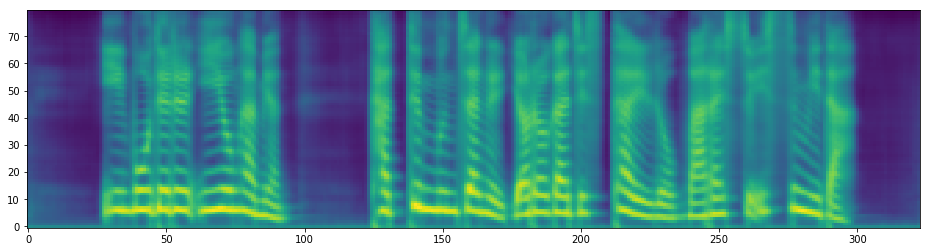

In [18]:
text = "이 모델을 이용하면 같은 문장을 여러가지 스타일로 말할 수 있습니다."
ref_wav = "/DATA2/jinhan/KoreanEmotionSpeech/wav/ang/ang_00000100.wav"
generate_mels_by_ref_audio(text, ref_wav)

ref_audio


None

tensor([[0.5545]], device='cuda:0') tensor([[0.2189]], device='cuda:0')


None

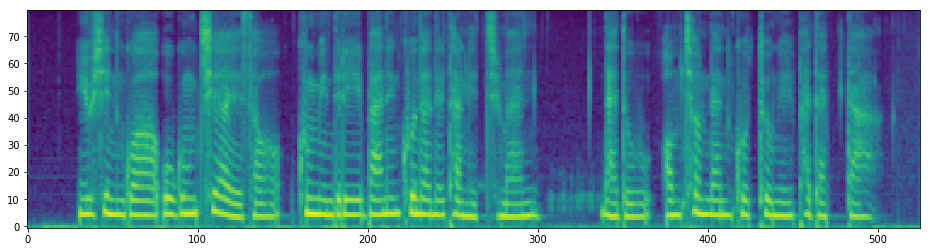

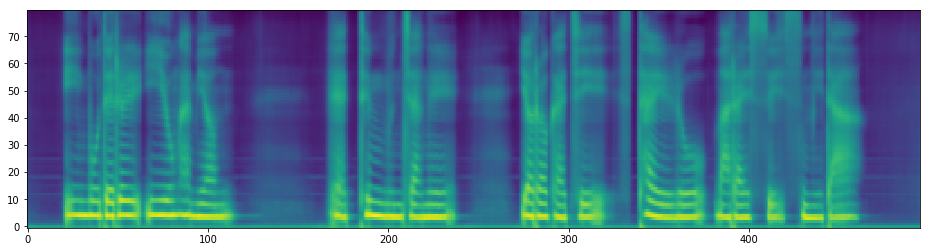

In [13]:
text = "이 모델을 이용하면 같은 문장을 여러가지 스타일로 말할 수 있습니다."
ref_wav = "/DATA2/jinhan/KoreanEmotionSpeech/wav/sad/sad_00000100.wav"
generate_mels_by_ref_audio(text, ref_wav)

## Condition on Style Tokens

In [19]:
def generate_mels_by_style_tokens(text):
    transcript_outputs = TextEncoder(text)
    GST = torch.tanh(model.gst.stl.embed)

    for idx in range(10):
        query = torch.zeros(1, 1, hparams.E//2).cuda()
        keys = GST[idx].unsqueeze(0).expand(1,-1,-1)
        style_emb = model.gst.stl.attention(query, keys)
        encoder_outputs = transcript_outputs + style_emb

        synth, mel_outputs = Decoder(encoder_outputs)

        print("token {}".format(idx))
        ipd.display(ipd.Audio(synth[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        ipd.display(plot_data(mel_outputs.data.cpu().numpy()[0]))

tensor([[0.5010]], device='cuda:0') tensor([[0.0042]], device='cuda:0')
token 0


None

Warning! Reached max decoder steps
token 1


None

tensor([[0.5568]], device='cuda:0') tensor([[0.2283]], device='cuda:0')
token 2


None

tensor([[0.5147]], device='cuda:0') tensor([[0.0587]], device='cuda:0')
token 3


None

tensor([[0.5084]], device='cuda:0') tensor([[0.0336]], device='cuda:0')
token 4


None

tensor([[0.5703]], device='cuda:0') tensor([[0.2830]], device='cuda:0')
token 5


None

tensor([[0.5593]], device='cuda:0') tensor([[0.2382]], device='cuda:0')
token 6


None

tensor([[0.5398]], device='cuda:0') tensor([[0.1595]], device='cuda:0')
token 7


None

tensor([[0.5649]], device='cuda:0') tensor([[0.2610]], device='cuda:0')
token 8


None

Warning! Reached max decoder steps
token 9


None

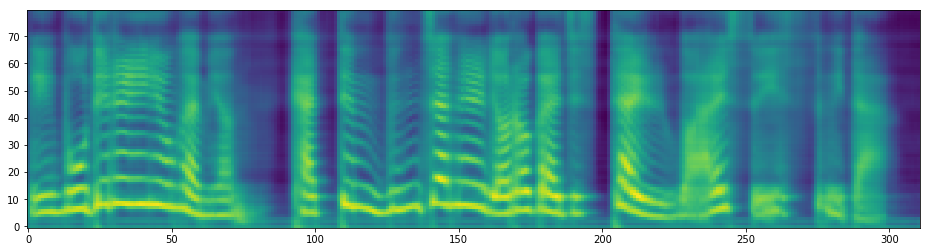

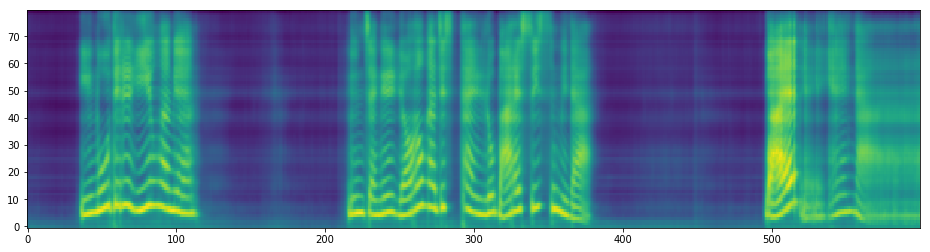

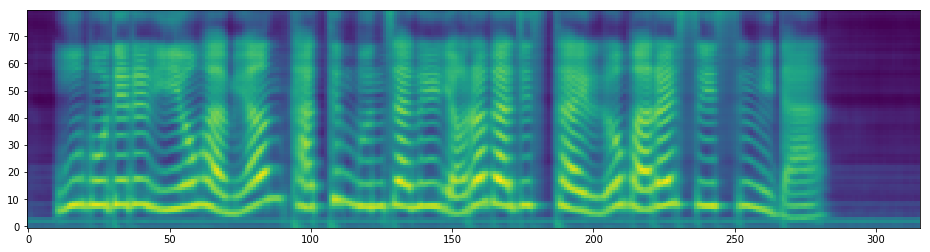

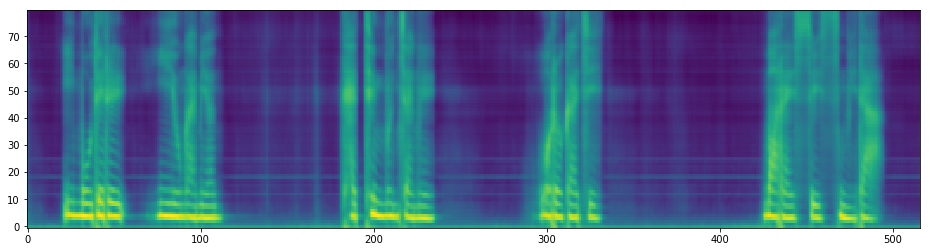

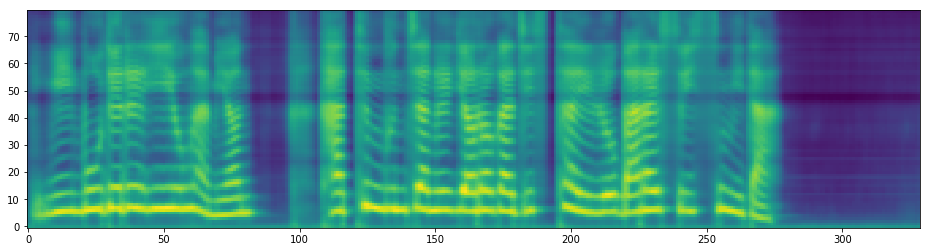

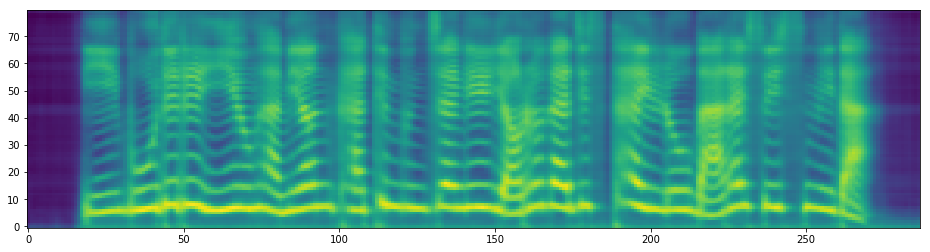

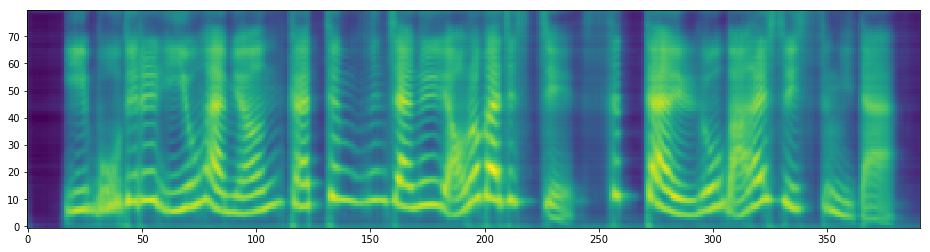

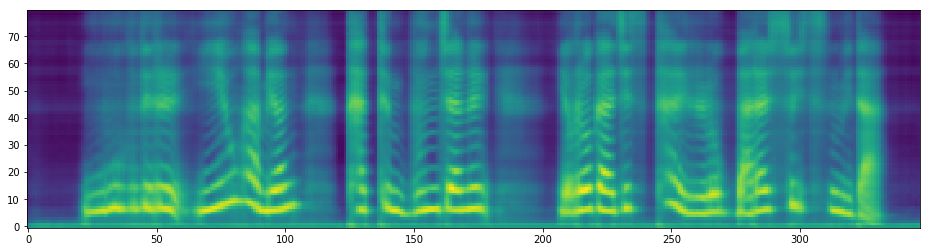

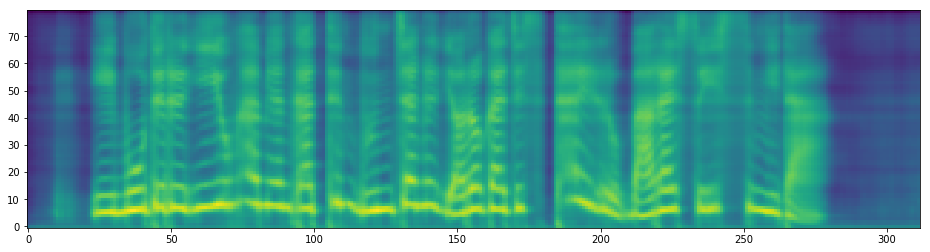

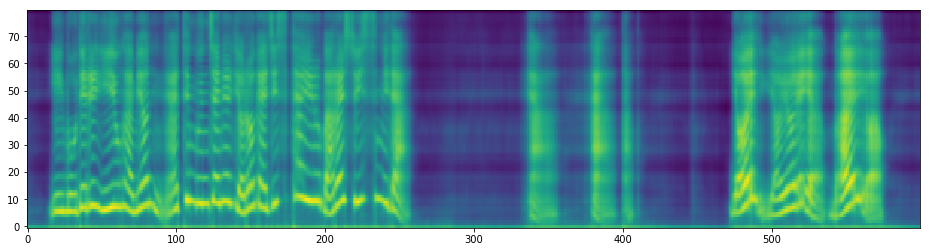

In [20]:
text = "이 모델을 이용하면 같은 문장을 여러가지 스타일로 말할 수 있습니다."
generate_mels_by_style_tokens(text)